In [174]:
import datetime as dt
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

company='SPY'
start = dt.datetime(2000,2,1)
end = dt.datetime(2021,2,1)
prediction_days=90

In [175]:
def train_model(company,start,end,prediction_days):
    #get data
    data =pdr.DataReader(company,'yahoo',start,end)
    data = data.reset_index(drop=False)
    #scale data and reshape for keras model
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))
    
    #create x and y train based on x prediction days before y 
    x_train = []
    y_train = []
    #create a matrix: row number of historical data and columns number of prediction days
    for x in range(prediction_days, len(scaled_data)):
        x_train.append(scaled_data[x-prediction_days:x,0])
        y_train.append(scaled_data[x,0])
        
    #reshape data for keras model
    x_train,y_train= np.array(x_train), np.array(y_train)
    x_train=np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    
    #build the model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #train the model
    model.fit(x_train, y_train, epochs=25, batch_size=32)
    
    return data,scaler,model

In [176]:
data,scaler,model=train_model(company,start,end,prediction_days)

Epoch 1/25
163/163 [==============================] - 21s 103ms/step - loss: 0.0060
Epoch 2/25
163/163 [==============================] - 19s 117ms/step - loss: 0.0015
Epoch 3/25
163/163 [==============================] - 22s 138ms/step - loss: 0.0015
Epoch 4/25
163/163 [==============================] - 20s 125ms/step - loss: 0.0014
Epoch 5/25
163/163 [==============================] - 26s 162ms/step - loss: 0.0012
Epoch 6/25
163/163 [==============================] - 22s 137ms/step - loss: 0.0012
Epoch 7/25
163/163 [==============================] - 18s 112ms/step - loss: 0.0011
Epoch 8/25
163/163 [==============================] - 20s 122ms/step - loss: 0.0010
Epoch 9/25
163/163 [==============================] - 18s 111ms/step - loss: 8.8336e-04
Epoch 10/25
163/163 [==============================] - 18s 111ms/step - loss: 8.6939e-04
Epoch 11/25
163/163 [==============================] - 20s 124ms/step - loss: 7.7519e-04
Epoch 12/25
163/163 [==============================] - 34s 210

In [181]:
def predict_stock(test_start,test_end,data,model,scaler,company):
    #Load test data
    data['Training']=0
    test_data=pdr.DataReader(company, 'yahoo', test_start,test_end)
    test_data = test_data.reset_index(drop=False)
    actual_prices=test_data['Close'].values
    test_data['Training']=1
    
    total_dataset=pd.concat((data[['Date','Close','Training']], test_data[['Date','Close','Training']]),axis=0)

    model_inputs=total_dataset[len(total_dataset)-len(test_data) - prediction_days:]['Close'].values
    
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs=scaler.transform(model_inputs)
        
    #prediction
    x_test=[]
    #create matrix x_test for the prediction
    for x in range(prediction_days,len(model_inputs)):
        x_test.append(model_inputs[x-prediction_days:x,0])
    
    #format to fit the model input shape
    x_test=np.array(x_test)
    x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
    #predict and scale back
    predicted_prices=model.predict(x_test)
    predicted_prices=scaler.inverse_transform(predicted_prices)
  
    total_dataset['Prediction']=0
    lenght=total_dataset.shape[0] - test_data.shape[0]
    for t in range(test_data.shape[0]):
        index=lenght+t
        total_dataset['Prediction'].iloc[index]=predicted_prices[t]
    total_dataset['Error%']=(total_dataset['Close']-total_dataset['Prediction'])/total_dataset['Close']*100
    #plot test
    plt.plot(total_dataset[total_dataset['Date']>=test_start]['Date'].values, total_dataset[total_dataset['Date']>=test_start]['Close'].values, color='black', label=f'Actual {company} price')
    plt.plot(total_dataset[total_dataset['Date']>=test_start]['Date'].values, total_dataset[total_dataset['Date']>=test_start]['Prediction'].values, color='green', label=f'Predicted {company} price')
    
    plt.title(f'{company} share price')
    plt.xlabel('Time')
    plt.ylabel(f'{company} share price')
    plt.legend()
    plt.show()
    
    plt.plot(total_dataset[total_dataset['Date']>=test_start]['Date'].values, total_dataset[total_dataset['Date']>=test_start]['Error%'].values, color='black')
   
    plt.title('Error%')
    plt.xlabel('Time')
    plt.ylabel('Error%')
    plt.show()
    
    sns.lineplot(data=total_dataset[total_dataset['Date'].dt.year>=2020],x='Date', y='Close',hue='Training')
    sns.lineplot(data=total_dataset[total_dataset['Date']>=test_start],x='Date', y='Prediction')
    
    return total_dataset


14/14 [==============================] - 1s 41ms/step


C:\Users\cni4\AppData\Local\Temp\ipykernel_26692\3243698859.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_dataset['Prediction'].iloc[index]=predicted_prices[t]


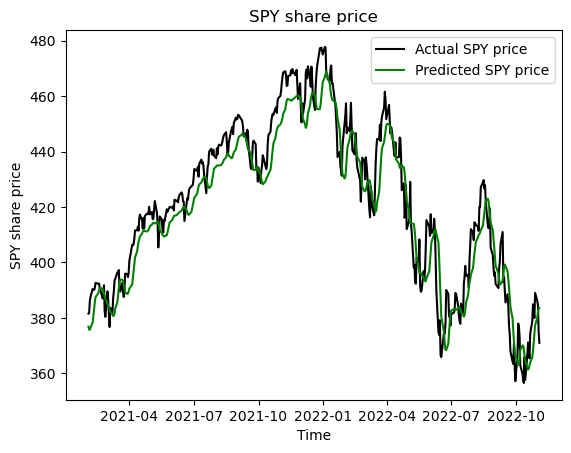

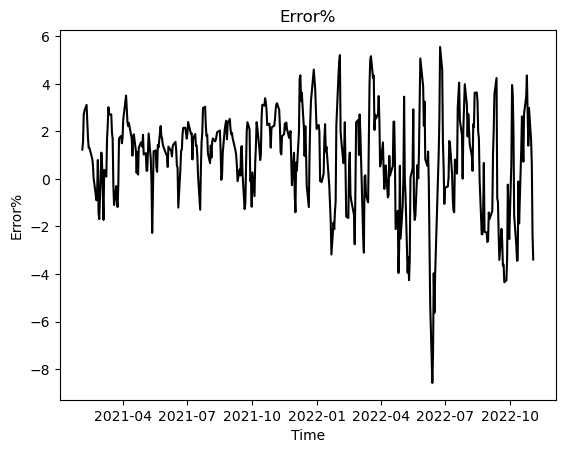

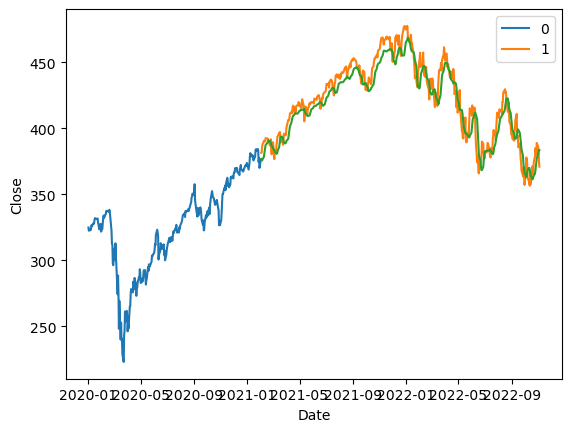

In [182]:
test_start = dt.datetime(2021,2,2)
test_end = dt.datetime(2022,11,3)
total_dataset=predict_stock(test_start,test_end,data,model,scaler,company)

<AxesSubplot:xlabel='Date', ylabel='Close'>

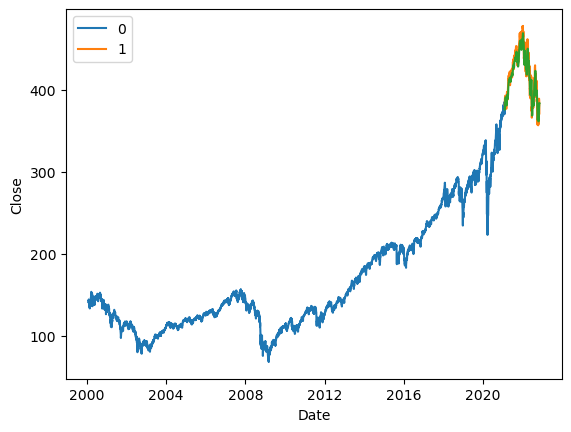

In [179]:
sns.lineplot(data=total_dataset,x='Date', y='Close',hue='Training')
sns.lineplot(data=total_dataset[total_dataset['Date']>=test_start],x='Date', y='Prediction')